# Activation visualization

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from numpy import expand_dims
import numpy as np

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Model definition and training

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 116s 1us/step


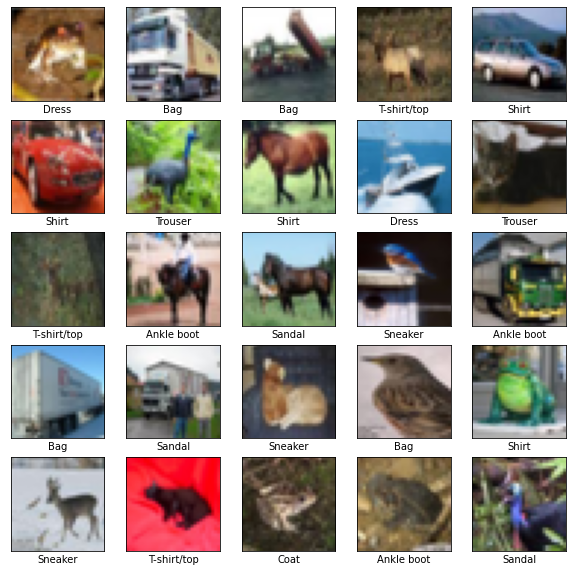

In [47]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5298 - accuracy: 0.4430 - val_loss: 1.2427 - val_accuracy: 0.5513
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1716 - accuracy: 0.5845 - val_loss: 1.0881 - val_accuracy: 0.6167
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.0155 - accuracy: 0.6438 - val_loss: 0.9821 - val_accuracy: 0.6576
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9125 - accuracy: 0.6796 - val_loss: 0.9124 - val_accuracy: 0.6825
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8440 - accuracy: 0.7044 - val_loss: 0.9794 - val_accuracy: 0.6629
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7804 - accuracy: 0.7271 - val_loss: 0.8672 - val_accuracy: 0.7011
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7323 - accuracy: 0.7442 - val_loss: 0.8591 - val_accuracy:

313/313 - 0s - loss: 0.8800 - accuracy: 0.7031


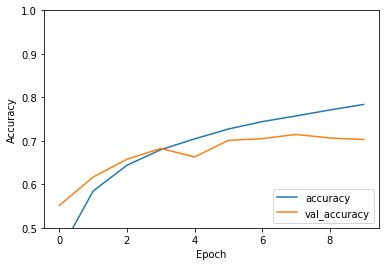

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Visualize activations

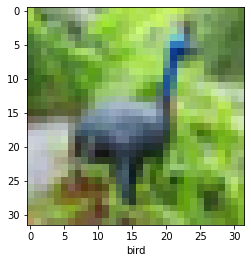

In [9]:
# select image
image_inx = 6
image = train_images[image_inx]
plt.imshow(image, cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[image_inx][0]])
plt.show()

### Kernel features

In [10]:
# find all conv layers and its shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 30, 30, 32)
2 conv2d_1 (None, 13, 13, 64)
4 conv2d_2 (None, 4, 4, 64)


In [11]:
# select convolutional layers
ixs = [0, 2, 4]
outputs = [model.layers[i].output for i in ixs]
activation_model = Model(inputs=model.inputs, outputs=outputs)

In [12]:
outputs

[<tf.Tensor 'conv2d/Relu:0' shape=(None, 30, 30, 32) dtype=float32>,
 <tf.Tensor 'conv2d_1/Relu:0' shape=(None, 13, 13, 64) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(None, 4, 4, 64) dtype=float32>]

Layer:  0


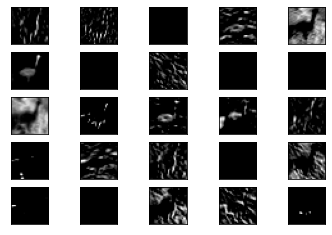

Layer:  1


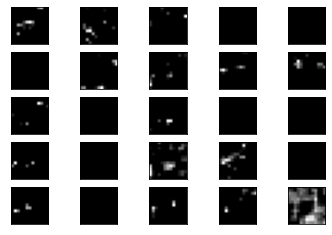

Layer:  2


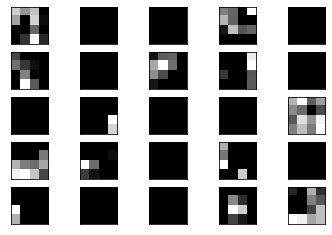

In [13]:
# get feature map for first hidden layer
img = expand_dims(image, axis=0)
feature_maps = activation_model.predict(img)

square = 5
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1 
    print('Layer: ', i)
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()


### Dense features

visualization of activation for different classes in dense layer

In [14]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'dense' not in layer.name and 'flatten' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

5 flatten (None, 1024)
6 dense (None, 64)
7 dense_1 (None, 10)


In [15]:
# select dense layers
dense_model = Model(inputs=model.inputs, outputs=model.layers[6].output)

In [16]:
# get feature map for first hidden layer
img = expand_dims(image, axis=0)
feature_maps = dense_model.predict(test_images)

# square = 5
# for i, fmap in enumerate(feature_maps):
#     # plot all 64 maps in an 8x8 squares
#     ix = 1 
#     print('Layer: ', i)
#     for _ in range(square):
#         for _ in range(square):
#             # specify subplot and turn of axis
#             ax = plt.subplot(square, square, ix)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             # plot filter channel in grayscale
#             plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
#             ix += 1
#     # show the figure
#     plt.show()

In [17]:
feature_maps.shape

(10000, 64)

In [18]:
!pip install scikit-learn

     |████████████████████████████████| 6.8 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 11.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=3)

In [21]:
x_pca = pca.fit_transform(feature_maps)

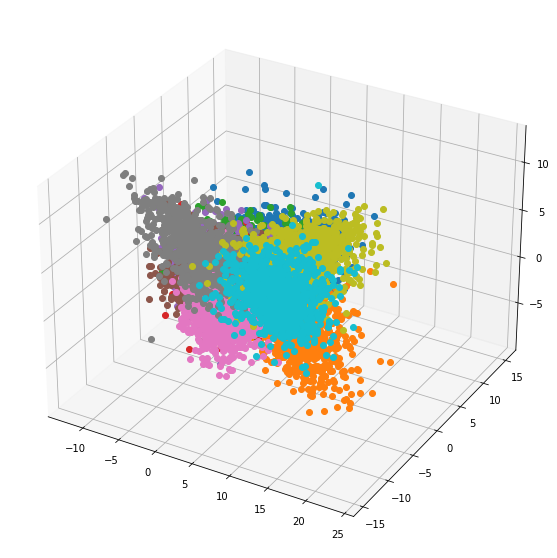

In [22]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection="3d")
for i in range(10):
    ax.plot(x_pca[test_labels.flatten() == i][:,0], 
             x_pca[test_labels.flatten() == i][:,1],
             x_pca[test_labels.flatten() == i][:,2], 'o')
plt.show()

### Analysis of activation on konvolutional layers

In [23]:
model.layers

In [24]:
# select dense layers
layers_model = Model(inputs=model.inputs, outputs=model.layers[3].output)

In [25]:
feature_maps = layers_model.predict(test_images)

In [26]:
feature_maps = feature_maps / feature_maps.max()

In [27]:
feature_maps.shape

(10000, 6, 6, 64)

In [28]:
layer_activations = feature_maps.reshape((feature_maps.shape[0], feature_maps.shape[1]*feature_maps.shape[2]*feature_maps.shape[3]))

In [29]:
layer_activations.shape

(10000, 2304)

### Histogram of neuron activations

<BarContainer object of 10 artists>

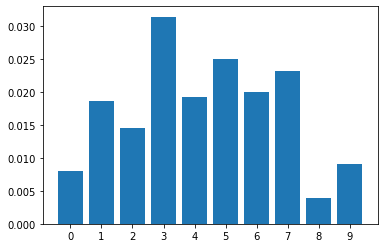

In [57]:
neuron_activations = layer_activations[:,1]
tast_labels_flatten = test_labels.flatten()
hist = []
for i in range(10):
    hist.append(neuron_activations[tast_labels_flatten == i].mean())
plt.bar(['0','1','2','3','4','5','6','7','8','9'], hist)

### Distribution of layer activations 

In [59]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(layer_activations)

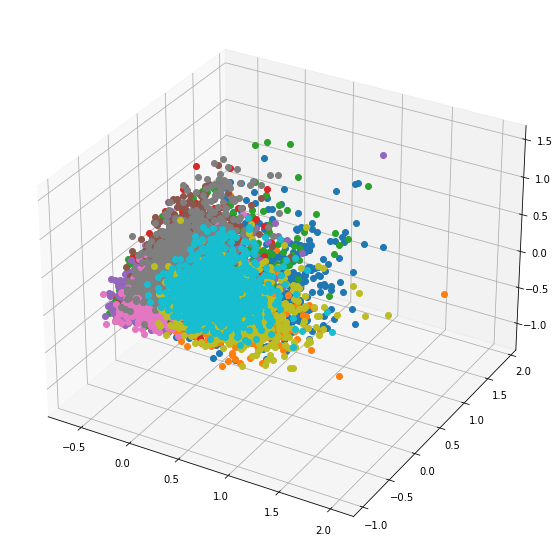

In [60]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection="3d")
for i in range(10):
    ax.plot(x_pca[tast_labels_flatten == i][:,0], 
             x_pca[tast_labels_flatten == i][:,1],
             x_pca[tast_labels_flatten == i][:,2], 'o')
plt.show()

### KNN on layer activations

In [24]:
model.layers

In [32]:
outputs = [
    model.layers[1].output,
    model.layers[3].output,
    model.layers[5].output,
    model.layers[6].output,
]

In [33]:
layers_model = Model(inputs=model.inputs, outputs=outputs)

In [42]:
layers_activations = layers_model.predict(test_images)
tast_labels_flatten = test_labels.flatten()

In [43]:
layers_activations[0] = layers_activations[0].reshape((layers_activations[0].shape[0], layers_activations[0].shape[1]*layers_activations[0].shape[2]*layers_activations[0].shape[3]))
layers_activations[1] = layers_activations[1].reshape((layers_activations[1].shape[0], layers_activations[1].shape[1]*layers_activations[1].shape[2]*layers_activations[1].shape[3]))

Layer:  0


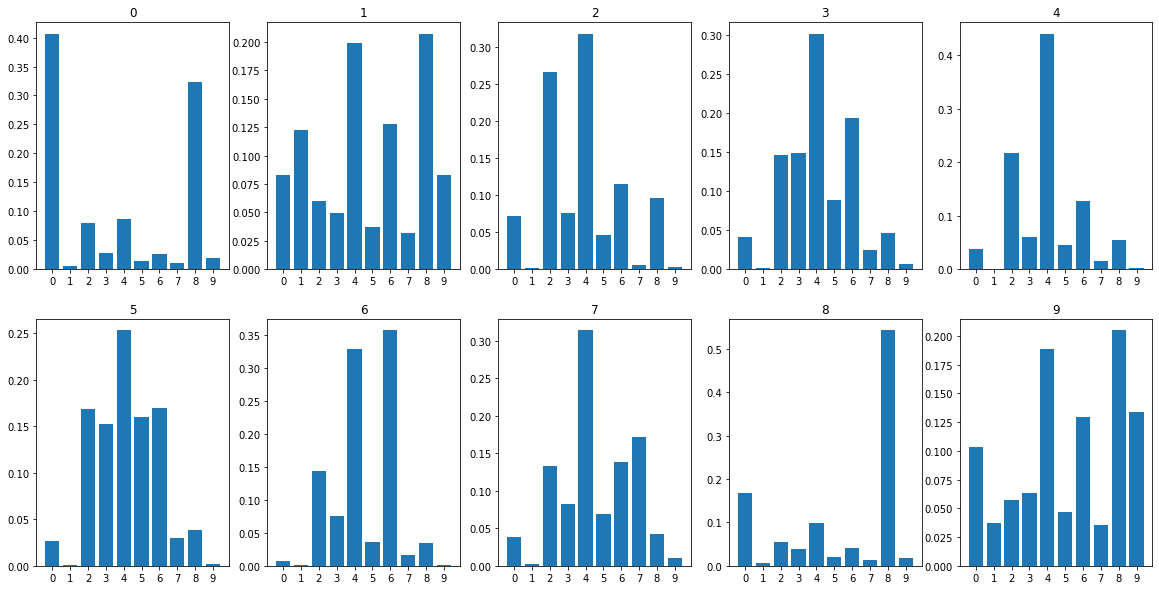

Layer:  1


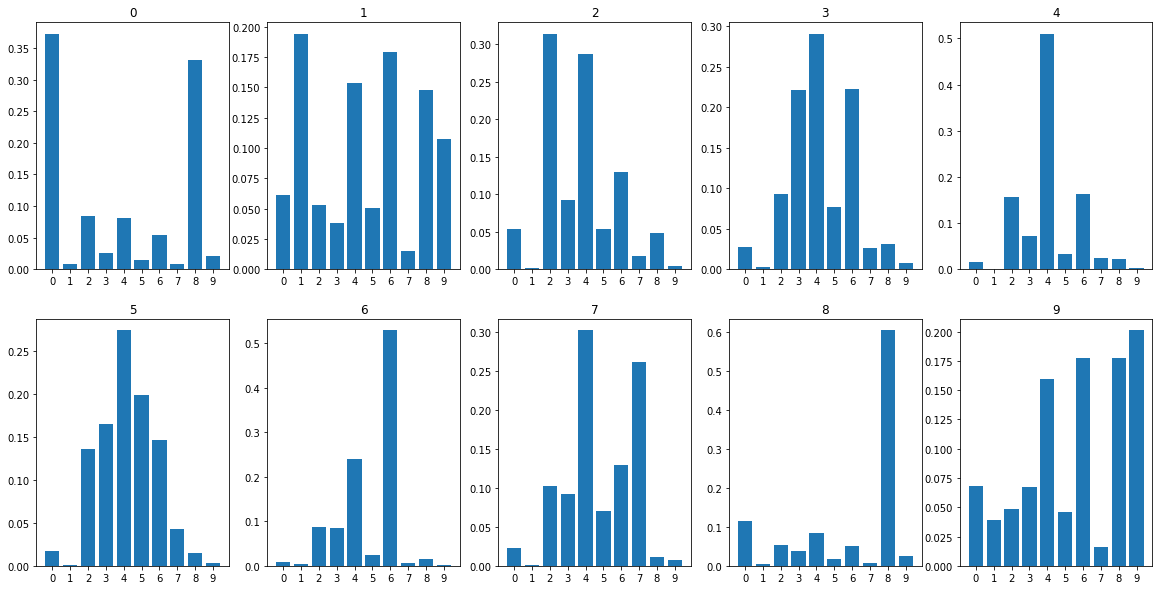

Layer:  2


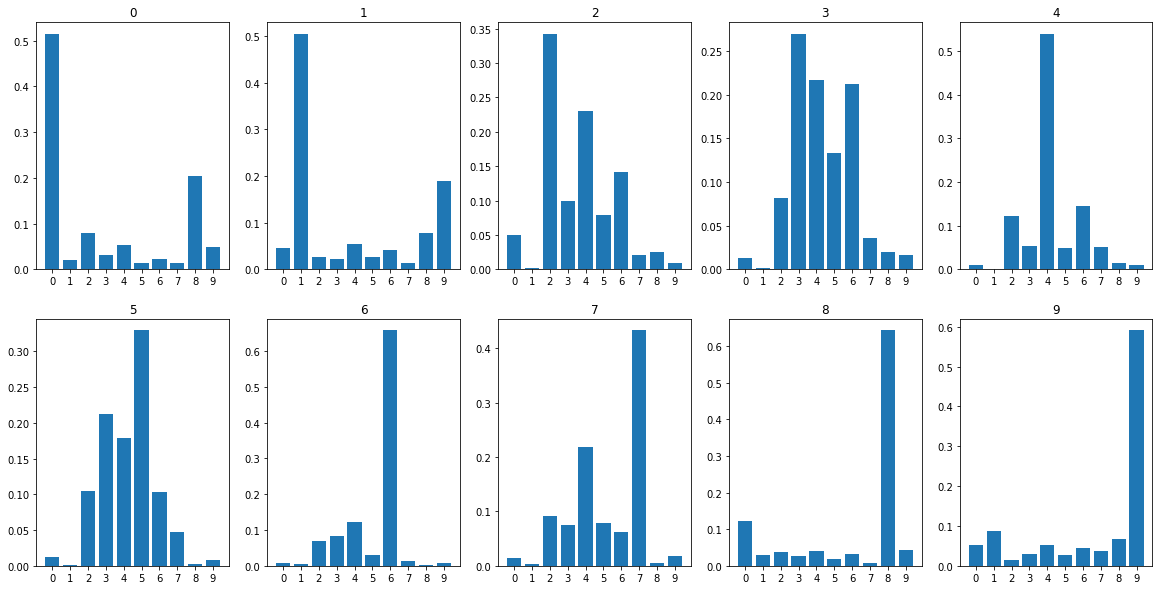

Layer:  3


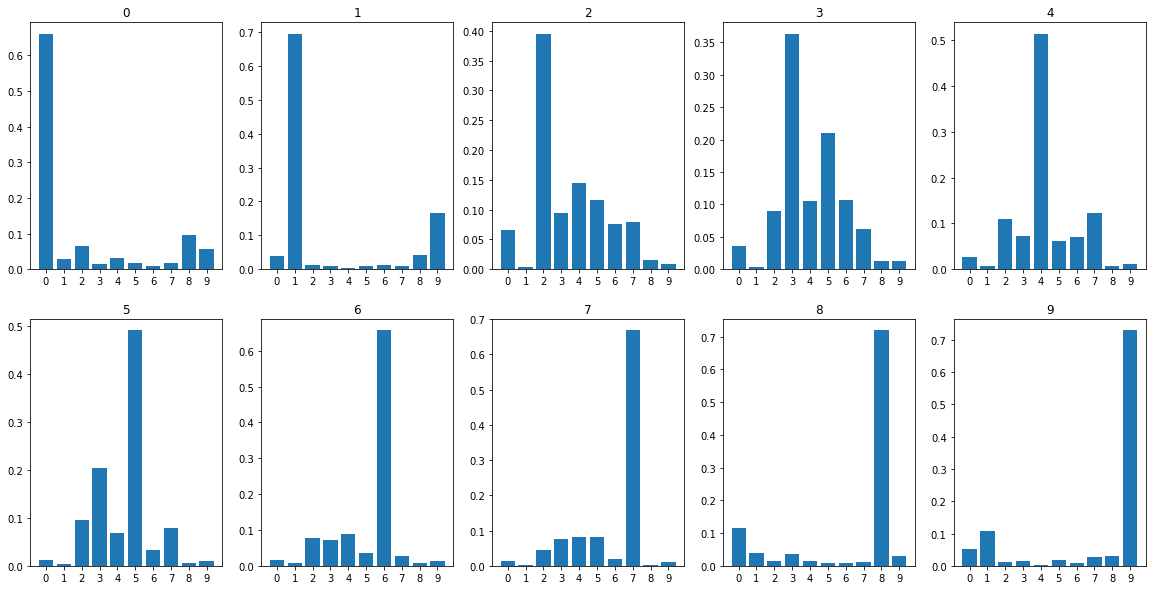

In [44]:
from sklearn.neighbors import KNeighborsClassifier

for i, layer_activations in enumerate(layers_activations):
    print('Layer: ')
    train_activations = layer_activations[:8000]
    train_labels = tast_labels_flatten[:8000]
    test_activations = layer_activations[8000:]
    test_labels = tast_labels_flatten[8000:]
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(train_activations, train_labels)
    
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    axs = axs.flatten()
    for i in range(10):
        pred = neigh.predict_proba(test_activations[test_labels == i])
        axs[i].bar(['0','1','2','3','4','5','6','7','8','9'], pred.mean(axis=0))
        axs[i].set_title(str(i))

    plt.show()